In [1]:
import torch
from utils.diffusionmodel import DiffusionModel

c:\Users\wolfg\OneDrive\Documents\Projects\OMI\my-omi-code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dit_params = {
    'channels': 384,
    'nBlocks': 8,
    'inC': 16, 
    'nHeads': 8,
    'patchSize': 2
}

cat_params = {
    'input_dim': 768,  # T5-base hidden size
    'hidden_dim': 512,
    'output_dim': 256,
    'num_layers': 3,
    'num_heads': 8
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionModel(dit_params = dit_params,
                       cat_params = cat_params,
                       device=device)

In [5]:
model

DiffusionModelPipeline {
    "_class_name": "DiffusionModel",
    "_diffusers_version": "0.30.3",
    "_name_or_path": "./",
    "device:", "cuda",
    "text_encoder": [
        "transformers",
        "T5EncoderModel"
    ],
    "tokenizer": [
        "transformers",
        "AutoTokenizer"
    ],
    "diffusion-model": [
        ".RectifiedFlow",
        "RectifiedFlow"
    ],
    "vae": [
        "diffusers",
        "AutoencoderKL"
    ],
    }

## Test Gen

In [6]:
image = model.generate('a beautiful sunset over the ocean', num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\wolfg\OneDrive\Documents\Projects\OMI\my-omi-code\utils\dit.py:105: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attnOutput = torch.nn.functional.scaled_dot_product_attention(q, k, v)
100%|██████████| 50/50 [00:01<00:00, 48.99it/s]


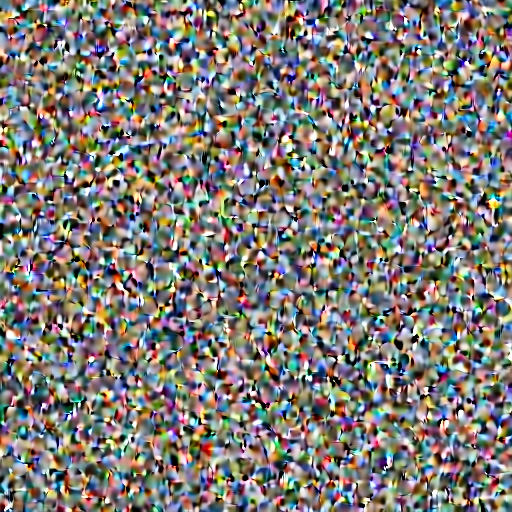

In [8]:
image[0]

## Test Training